In [1]:
!pip install mne numpy matplotlib scipy 



Procesando archivo 1: Hand open/close
Loading C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_001\2025-04-04_001.snirf
Reading 0 ... 6701  =      0.000 ...   658.708 secs...
  Frecuencia de muestreo: 10.172939979654121 Hz
  Canales: 44 canales
  Duración: 658.71 segundos
Used Annotations descriptions: [np.str_('1'), np.str_('2')]
  Eventos encontrados en archivo: 29
  Tipos de eventos: {np.str_('1'): 1, np.str_('2'): 2}
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 0.50 Hz: -6.02, -6.02 dB

  ✓ Archivo procesado exitosamente

Procesando archivo 2: Wrist rotation
Loading C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_002\2025-04-04_002.snirf
Reading 0 ... 6863  =      0.000 ...   674.633 secs...
  Frecue

<Figure size 1500x600 with 0 Axes>

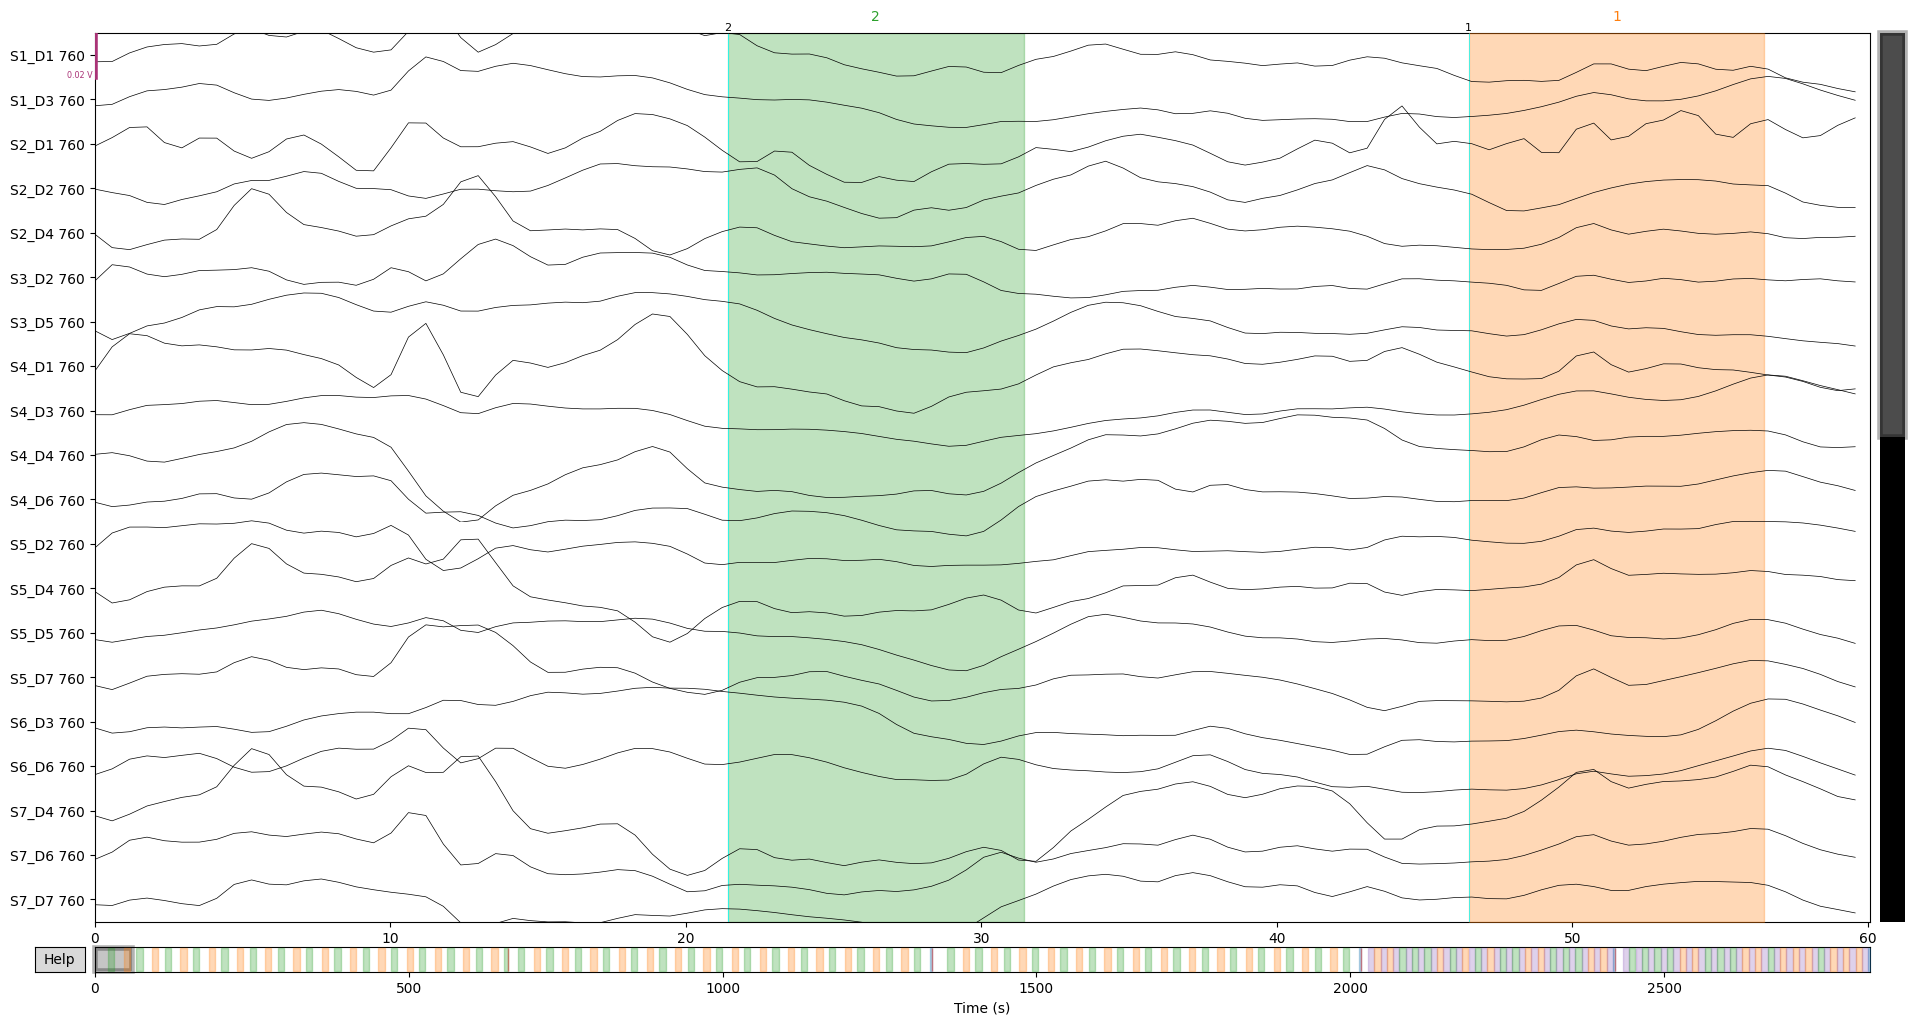

<Figure size 640x480 with 0 Axes>

Writing c:\Users\PC\OneDrive - Universidad de Deusto\Documentos\nirs_web_app\nirs-analysis-backend\uploads\Datos_Combinados_raw.fif.gz
Closing c:\Users\PC\OneDrive - Universidad de Deusto\Documentos\nirs_web_app\nirs-analysis-backend\uploads\Datos_Combinados_raw.fif.gz
[done]

¡Archivos fusionados exitosamente en 'nirs-analysis-backend/uploads/Datos_Combinados_raw.fif.gz'!


In [2]:
import mne
import numpy as np
from mne.preprocessing.nirs import optical_density
import matplotlib.pyplot as plt

# Rutas de los archivos .snirf
file_paths = [
    r'C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_001\2025-04-04_001.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_002\2025-04-04_002.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_003\2025-04-04_003.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_004\2025-04-04_004.snirf',
    r'C:\Users\PC\Downloads\drive-download-20250404T161722Z-001\2025-04-04_005\2025-04-04_005.snirf',
]

# MODIFICACIÓN PRINCIPAL: Definición de códigos consistentes para todos los archivos
# 0 = Rest (en todos los archivos)
# 1 = Ejercicio real (en todos los archivos)
# 2 = Imaginación/actividad cognitiva adicional
file_tasks = [
    # Archivos 1-3: ejercicios manuales reales
    {
        'name': 'Hand open/close',
        'event_map': {1: 'Real_movement', 0: 'Rest'}  # Ahora 1=Real, 0=Rest
    },
    {
        'name': 'Wrist rotation',
        'event_map': {1: 'Real_movement', 0: 'Rest'}  # Mismo patrón
    },
    {
        'name': 'Tapping',
        'event_map': {1: 'Real_movement', 0: 'Rest'}  # Mismo patrón
    },
    # Archivos 4-5: imaginación y ejercicios con componente cognitivo
    {
        'name': 'Movement imagination',
        'event_map': {2: 'Mov_imagination', 1: 'Real_movement', 0: 'Rest'}  # 2=Imaginación
    },
    {
        'name': 'Hand open/close with math',
        'event_map': {2: 'Movement_with_math', 1: 'Real_movement', 0: 'Rest'}  # 2=Con matemáticas
    }
]

# Lista para almacenar los datos procesados
processed_raws = []

# Procesar cada archivo
for i, (file_path, task_info) in enumerate(zip(file_paths, file_tasks)):
    print(f"\nProcesando archivo {i+1}: {task_info['name']}")
    
    try:
        # Cargar el archivo SNIRF
        raw = mne.io.read_raw_snirf(file_path, preload=True)
        print(f"  Frecuencia de muestreo: {raw.info['sfreq']} Hz")
        print(f"  Canales: {len(raw.info['ch_names'])} canales")
        print(f"  Duración: {raw.times[-1]:.2f} segundos")
        
        # Extraer eventos existentes del archivo SNIRF si existen
        events_from_snirf = None
        try:
            events_from_snirf, event_id = mne.events_from_annotations(raw)
            print(f"  Eventos encontrados en archivo: {len(events_from_snirf)}")
            print(f"  Tipos de eventos: {event_id}")
        except Exception as e:
            print(f"  No se pudieron extraer eventos automáticamente: {e}")
        
        # Si no hay eventos o son pocos, generamos manualmente según el patrón esperado
        if events_from_snirf is None or len(events_from_snirf) < 3:
            print("  Generando eventos manualmente según patrón")
            
            # Duración total del registro
            total_duration = raw.times[-1]
            
            # Para archivos 1-3 (ejercicio real/descanso)
            if i < 3:
                # Crear eventos para ejercicio real (código 1) y descanso (código 0)
                onsets = np.arange(0, total_duration - 20, 30)  # Cada 30 segundos un nuevo bloque
                
                # Crear anotaciones
                descriptions = []
                durations = []
                
                for j, onset in enumerate(onsets):
                    if j % 2 == 0:  # Ejercicio
                        descriptions.append(task_info['event_map'][1])  # Real_movement
                        durations.append(15)  # 15 segundos de ejercicio
                    else:  # Descanso
                        descriptions.append(task_info['event_map'][0])  # Rest
                        durations.append(15)  # 15 segundos de descanso
                
            # Para archivos 4-5 (imaginación/real/descanso)
            else:
                # Crear eventos para los 3 tipos
                onsets = np.arange(0, total_duration - 15, 45)  # Cada 45 segundos un nuevo ciclo completo
                
                # Crear anotaciones
                descriptions = []
                durations = []
                
                for j, onset in enumerate(onsets):
                    # En cada ciclo: ejercicio tipo 2, descanso, ejercicio tipo 1, descanso
                    base_onset = onset
                    
                    # Primer ejercicio (imaginación o con matemáticas - código 2)
                    descriptions.append(task_info['event_map'][2])
                    durations.append(15)
                    onsets = np.append(onsets, base_onset)
                    
                    # Descanso (código 0)
                    descriptions.append(task_info['event_map'][0])
                    durations.append(10)
                    onsets = np.append(onsets, base_onset + 15)
                    
                    # Segundo ejercicio (real - código 1)
                    descriptions.append(task_info['event_map'][1])
                    durations.append(15)
                    onsets = np.append(onsets, base_onset + 25)
                
                # Eliminar el valor original que usamos como base
                onsets = onsets[1:]
            
            # Crear y añadir las anotaciones
            annotations = mne.Annotations(onset=onsets,
                                         duration=durations,
                                         description=descriptions)
            raw.set_annotations(annotations)
            print(f"  Añadidas {len(annotations)} anotaciones manualmente")
        
        # Convertir a densidad óptica
        raw_od = optical_density(raw)
        
        # Filtrar (opcional - ajustar según necesidades)
        raw_od.filter(0.01, 0.5, picks='fnirs', method='iir')
        
        # Añadir a la lista de procesados
        processed_raws.append(raw_od)
        print(f"  ✓ Archivo procesado exitosamente")
        
    except Exception as e:
        print(f"  ERROR al procesar archivo: {e}")

# Verificar si hay datos procesados antes de continuar
if not processed_raws:
    raise ValueError("No hay archivos procesados para combinar")

# Verificar si las frecuencias de muestreo son iguales
sfreqs = [raw.info['sfreq'] for raw in processed_raws]
if len(set(sfreqs)) > 1:
    raise ValueError("Las frecuencias de muestreo no coinciden entre los archivos")

# Fusionar los archivos 
merged_raw = mne.concatenate_raws(processed_raws)

# Visualizar las anotaciones resultantes
print("\nAnotaciones en el archivo combinado:")
for i, annot in enumerate(merged_raw.annotations):
    print(f"{i+1}. {annot['description']} - inicio: {annot['onset']:.1f}s, duración: {annot['duration']:.1f}s")

# Visualizar los eventos en el archivo combinado
fig = plt.figure(figsize=(15, 6))
merged_raw.plot(events=mne.events_from_annotations(merged_raw)[0], 
               event_id=mne.events_from_annotations(merged_raw)[1],
               duration=60, scalings='auto', title='Eventos en datos combinados')
plt.tight_layout()
plt.show()

# Guardar el archivo fusionado en formato .fif (comprimido)
output_path = 'nirs-analysis-backend/uploads/Datos_Combinados_raw.fif.gz'
merged_raw.save(output_path, overwrite=True)

print(f"\n¡Archivos fusionados exitosamente en '{output_path}'!")